<a href="https://colab.research.google.com/github/Ashi743/ML-practices/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-cancer-wisconsin-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F180%2F408%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240722%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240722T184605Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8f84c47143782c520c8b61da230eae495ce39893bf9f6b20b0b82cde86e843038c506937260ae0a8e22165ae69d0bdba90bdd850daffff7d3f5fca21e13bac83e2c13ef22530558d3873e94c8d8ec7b4a48157ad1fa51af5b485650df55c9fc682ebcda663f14177b06b284479cf948e98b1e1606d501fc8b6f0e0ccbaca8cfebdec2990ab1d7c39595e0be4ebafff604a14a6ee5a792f085a5fa8e8bd8d8b9e903c60005186352e274363be02ce0eab8a48118b931f1fd5bf529ef5ad7e5974d4d533d82d5aeccd200d5db5f907281962fad2a00a94e59e2b1fe18cad77ee5c9da8c083574dad3338ba80345c8291999fb7063fa74cf04c1f17e949657a25a4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 49796 bytes downloaded
Downloaded and uncompressed: breast-cancer-wisconsin-data
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-wisconsin-data/data.csv


In [ ]:
df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')


In [ ]:
df.drop(columns= ["id", "Unnamed: 32"], inplace= True)

In [ ]:
df.head()
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
df['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [ ]:
df['diagnosis'].replace({"B":"benign", "M":"Malignant"},inplace= True)

In [ ]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,Malignant,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,Malignant,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,Malignant,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,Malignant,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,Malignant,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
x=df.iloc[:, 1:]
y=df.iloc[:, 0 ]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,
                                                 test_size=0.2, random_state= 2)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
x_train= scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors= 1)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred= knn.predict(x_test)
accuracy_score(y_test, y_pred)

0.956140350877193

In [ ]:
scores= []
for i in range(1,16):
  knn= KNeighborsClassifier(n_neighbors= i)
  knn.fit(x_train, y_train)
  y_pred= knn.predict(x_test)
  scores.append(accuracy_score(y_test, y_pred))
score_dict = {i: scores[i-1] for i in range(1, 16)}
score_dict

{1: 0.956140350877193,
 2: 0.9473684210526315,
 3: 0.9736842105263158,
 4: 0.9736842105263158,
 5: 0.9736842105263158,
 6: 0.9736842105263158,
 7: 0.9736842105263158,
 8: 0.9736842105263158,
 9: 0.9736842105263158,
 10: 0.9736842105263158,
 11: 0.9736842105263158,
 12: 0.9736842105263158,
 13: 0.9649122807017544,
 14: 0.9649122807017544,
 15: 0.9649122807017544}

In [72]:
# For best n_neighbours
import math
n = df.shape[0]
k_max = math.sqrt(n)
kN_max= np.round(k_max)
kN_max

24.0

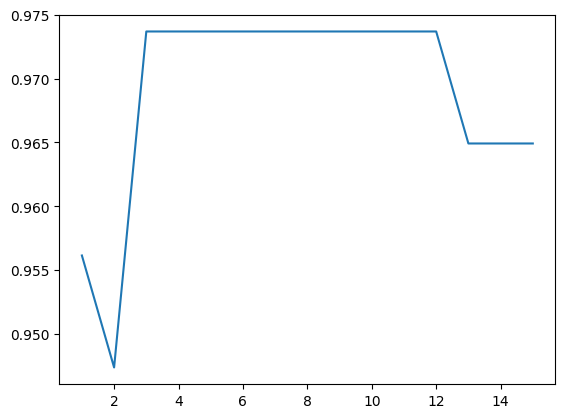

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,16),scores)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.preprocessing import StandardScaler
from ipywidgets import interact, fixed

def load_data():
    cancer = datasets.load_breast_cancer()
    return cancer

def plot_decision_boundaries(n_neighbors, data, labels):
    h = .08
    cmap_light = ListedColormap(['orange', 'blue'])
    cmap_bold = ListedColormap(['darkorange', 'darkblue'])

    clf = neighbors.KNeighborsClassifier(n_neighbors)
    clf.fit(data, labels)

    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'2-Class classification (k = {n_neighbors})')
    plt.show()

cancer = load_data()

# Use only the first two features and standardize them.
X = StandardScaler().fit_transform(cancer.data[:, :2])
y = cancer.target

# Interactive widget
interact(plot_decision_boundaries, n_neighbors=(1, kN_max), data=fixed(X), labels=fixed(y));


interactive(children=(FloatSlider(value=12.5, description='n_neighbors', max=24.0, min=1.0), Output()), _dom_c…

In [66]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
from IPython.display import display

# Load the dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to train and evaluate KNN
def evaluate_knn(n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {n_neighbors} neighbors: {accuracy:.4f}")

# Create a slider for selecting the number of neighbors
neighbors_slider = widgets.IntSlider(value=1, min=1, max=15, step=1, description='Neighbors:', continuous_update=False)

# Use interactive to update the function output
widgets.interactive_output(evaluate_knn, {'n_neighbors': neighbors_slider})

# Display the slider
display(neighbors_slider)


IntSlider(value=1, continuous_update=False, description='Neighbors:', max=15, min=1)